### Imports

In [1]:
import os
import torch
import imageio
import numpy as np
from torch import nn
import torch.optim as optim
from scipy.io import savemat
from scipy.io import loadmat
import matplotlib.pyplot as plt
from PIV_PINN_model_copy import StreamfunctionNetwork, HydroNetwork, WeakPINN

### Import data and make grids

In [11]:
data_path = '/Users/darinmomayezi/Documents/Research/SchatzLab/Our Papers/Model Discovery Symmetric Jack/codeAndData/Data/SymmetricJack1/'

# FLUID DATA

mat = loadmat(data_path + 'pivmeasurement.mat')
# for key, value in mat.items(): print(key)

# Get spacetime coordinates (x, y, t) and velocity components (u, v)
x, y, t, u, v = mat['x'], mat['y'], np.linspace(0, len(mat['x'])-1, len(mat['x'])), \
    mat['u_smoothed'], mat['v_smoothed']

x_0, x_final, x_len = int(x[0][0][0][0]), int(x[0][0][0][-1]), len(x[0][0][0])
y_0, y_final, y_len = int(y[0][0][0][0]), int(y[0][0][-1][0]), len(y[0][0][0])

# x_0, x_final, x_len = 1, 10, 10
# y_0, y_final, y_len = 1, 10, 10

x_grid, y_grid = torch.linspace(x_0, x_final, x_len, requires_grad=True), \
    torch.linspace(y_0, y_final, y_len, requires_grad=True)
    
# Single frame grids (for just one snapshot)
x_0, x_1, x_final, x_len = int(x[0][0][0][0]), int(x[0][0][0][1]), int(x[0][0][0][-1]), len(x[0][0][0])
y_0, y_1, y_final, y_len = int(y[0][0][0][0]), int(y[0][0][1][0]), int(y[0][0][-1][0]), len(y[0][0])

x_grid, y_grid = torch.linspace(x_0, x_final, int((x_final)/(x_1 - x_0)), requires_grad=True), \
    torch.linspace(y_0, y_final, int((y_final)/(y_1 - y_0)), requires_grad=True)
    
x_grid, y_grid, t_grid = torch.linspace(0, x_len-1, x_len, requires_grad=True), \
    torch.linspace(0, y_len-1, y_len, requires_grad=True), torch.linspace(0, int(t[-1]), int(t[-1]+1), requires_grad=True)
    
# x_grid, y_grid = x_grid[0::2], y_grid[0::2]

X, Y = torch.meshgrid( (x_grid, y_grid) )
Y, X, T = torch.meshgrid( (y_grid, x_grid, t_grid) )

# PARTICLE DATA

# particle1, particle2, particle3, particle4, COM = np.genfromtxt(file_path, delimiter=',', skip_header=1)
COM = np.genfromtxt(data_path + 'COM_data.csv', delimiter=',')[:-1]  # Take off the last row where I have the dimensions of the box : not needed here
particle1, particle2, particle3, particle4 = np.genfromtxt(data_path + 'particle1_data.csv', delimiter=','), np.genfromtxt(data_path + 'particle2_data.csv', delimiter=','), \
                                             np.genfromtxt(data_path + 'particle3_data.csv', delimiter=','), np.genfromtxt(data_path + 'particle4_data.csv', delimiter=',')

particle_data = (COM, particle1, particle2, particle3, particle4)
print(x_final, y_final)

705 1265


### Visual Checks

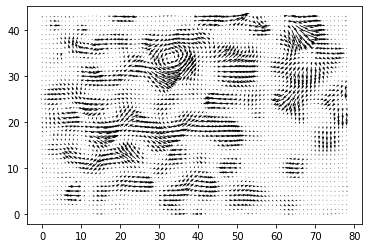

In [3]:
# VISUALIZATIONS

# # Check the uniform grid
# # flatten the arrays
# X_flat = X.detach().numpy().flatten()
# Y_flat = Y.detach().numpy().flatten()

# # flot the points
# plt.scatter(X_flat, Y_flat, color='blue', s=1)  # Plotting the points
# plt.title('2D Grid of Points')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.grid(True)
# plt.show()

# Check the input flow field
plt.quiver(Y.detach().numpy(), X.detach().numpy(), v[100][0], u[100][0])
plt.show()


### Make NN

In [5]:

X = torch.reshape( X, [-1,1] )
Y = torch.reshape( Y, [-1,1] )
T = torch.reshape( T, [-1,1] )

xs      = torch.cat( (X,Y,T), dim=1 )
xs_uniform = xs.clone().detach()
frame = 0


# Parameters
epochs = 20000

nu = 1.0/40 #fluid viscosity
p  = 5      #points for Gaussian quadrature

stream_model = StreamfunctionNetwork( L=64 )
hydro_model = HydroNetwork( stream_model )
pinn = WeakPINN( hydro_model, nu , p )

psi = stream_model.forward(xs)
f   = hydro_model.forward(xs)
err = pinn.forward(xs, xs_uniform, hydro_model, (u[0][0], v[0][0]), (x_grid, y_grid, t_grid), particle_data, frame)

criterion = nn.MSELoss()

optimizer = optim.Adam(hydro_model.parameters(), lr=0.001)

loss_history = torch.zeros( (epochs) )

def save_network_output( hydro_model, out_name, grids ):
    # After training, you can use the trained model for predictions
    ns=(79,44, 315)
    
    x_grid, y_grid = grids[0], grids[1]
    [y,x] = torch.meshgrid( (y_grid, x_grid) )

    x = torch.reshape( x, [-1,1] )
    y = torch.reshape( y, [-1,1] )

    xs      = torch.cat( (x,y), dim=1 )
    f_final = hydro_model.forward(xs)  # contains [w, u, v, T, a]

    f_final = f_final.detach().numpy()
    x_grid  = x_grid.detach().numpy()
    y_grid  = y_grid.detach().numpy()

    f_final = np.reshape( f_final, [ns[0], ns[1], -1] )

    out_dict =  {"f": f_final, "x_grid": x_grid, "y_grid": y_grid, "loss_history": loss_history }
    savemat(out_name, out_dict)


def closure():
    optimizer.zero_grad()  # Clear gradients
    err = pinn.forward(xs)
    # Compute the MSE loss
    loss = criterion(err.float(), torch.zeros_like(err).float())
    #loss.backward()  # Backward pass
    loss.backward(retain_graph=True)   # compute gradients
    return loss

### Run training loop

In [4]:
for frame in range(len(t)):
    true_data = (u[frame][0], v[frame][0])

    if os.path.exists('/Users/darinmomayezi/Desktop/pinnModel3.pth'): 
        pinn.load_state_dict(torch.load('/Users/darinmomayezi/Desktop/pinnModel3.pth'))
        pinn.eval()

    for epoch in range(epochs):
        # Forward pass
        err = pinn.forward(xs, xs_uniform, hydro_model, true_data, (x_grid, y_grid), particle_data, frame)

        # Compute the MSE loss
        loss = criterion(err, torch.zeros_like(err))  # assuming you want to minimize pinn.forward(xs) to zero

        # Backward pass and optimization step
        optimizer.zero_grad()  # clear previous gradients
        loss.backward(retain_graph=True)   # compute gradients
        optimizer.step()  # update model parameters
        # save_network_output(hydro_model, 'lol')
        # Print the loss every few epochs
        if epoch % 100 == 0:
            print(f"Frame {frame}, Epoch {epoch}/{epochs}, Loss: {loss.item()}")
        if epoch == epochs - 1:
            save_network_output( hydro_model, 
                "/Users/darinmomayezi/Documents/Research/SchatzLab/Codes/PINNs/network_output2/torch_output_frame%d_%d.mat" % (frame, epoch), (x_grid, y_grid) )
            # print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")

    # Save the model to reload for the next frame
    torch.save(pinn.state_dict(), '/Users/darinmomayezi/Desktop/pinnModel3.pth')

# Make gif
filenames = [f'/Users/darinmomayezi/Desktop/images/input{i}.png' for i in range(len(t))]

# Create a GIF from the images
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('/Users/darinmomayezi/Desktop/animation.gif', images, fps=5)

Frame 0, Epoch 0/1, Loss: 5.583316326141357
Frame 1, Epoch 0/1, Loss: 1.7839164733886719
Frame 2, Epoch 0/1, Loss: 1.9377373456954956
Frame 3, Epoch 0/1, Loss: 3.383936882019043
Frame 4, Epoch 0/1, Loss: 2.7356629371643066
Frame 5, Epoch 0/1, Loss: 3.6748206615448
Frame 6, Epoch 0/1, Loss: 1.2760813236236572
Frame 7, Epoch 0/1, Loss: 2.1216673851013184
Frame 8, Epoch 0/1, Loss: 3.0558106899261475
Frame 9, Epoch 0/1, Loss: 2.592794179916382
Frame 10, Epoch 0/1, Loss: 1.4714909791946411
Frame 11, Epoch 0/1, Loss: 3.229419231414795
Frame 12, Epoch 0/1, Loss: 7.780661582946777
Frame 13, Epoch 0/1, Loss: 3.0967791080474854
Frame 14, Epoch 0/1, Loss: 3.5638630390167236
Frame 15, Epoch 0/1, Loss: 3.037909984588623
Frame 16, Epoch 0/1, Loss: 4.130068302154541
Frame 17, Epoch 0/1, Loss: 8.481793403625488
Frame 18, Epoch 0/1, Loss: 5.738129615783691
Frame 19, Epoch 0/1, Loss: 3.5101253986358643
Frame 20, Epoch 0/1, Loss: 3.8756399154663086
Frame 21, Epoch 0/1, Loss: 5.855056285858154
Frame 22, E

/var/folders/87/8h9n2jzs30b3_z91kyw3_zr80000gn/T/ipykernel_69183/2129661210.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


Particle 1:  [509.00190235 459.99639042]
Particle 2:  [607.9987845 478.9691061]
Particle 3:  [490.99104034 555.98279746]
Particle 4:  [589.95751951 577.0475292 ]


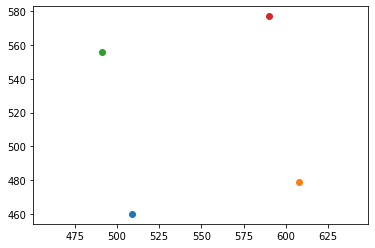

4.506470586943473


/var/folders/87/8h9n2jzs30b3_z91kyw3_zr80000gn/T/ipykernel_40937/4149711241.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [7]:
# FIGURE OUT WHICH PARTICLES ARE WHERE

print('Particle 1: ', particle1[0][1:])
print('Particle 2: ', particle2[0][1:])
print('Particle 3: ', particle3[0][1:])
print('Particle 4: ', particle4[0][1:])


plt.scatter(particle1[0][1], particle1[0][2], marker='o')
plt.scatter(particle2[0][1], particle2[0][2], marker='o')
plt.scatter(particle3[0][1], particle3[0][2], marker='o')
plt.scatter(particle4[0][1], particle4[0][2], marker='o')
plt.axis('equal')
plt.show()

# particles 1 and 4 make a side and particles 2 and 3 make the other side of the jack
radius = np.linalg.norm( abs( COM[0][1:] - particle1[0][1:] ) )
print(radius*79/1240)


# Make gif
filenames = [f'/Users/darinmomayezi/Desktop/images/input{i}.png' for i in range(len(t))]

# Create a GIF from the images
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('/Users/darinmomayezi/Desktop/animation.gif', images, fps=5)  # 'fps' is frames per second